In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
mvc = pd.read_csv("nypd_mvc_2018.csv")

In [4]:
mvc.shape

(57864, 26)

In [3]:
mvc.isnull().sum()

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64

In [5]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:,:3].sum(axis=1)
killed_mask = killed['total_killed']!=killed_manual_sum

killed_non_eq = killed[killed_mask]

In [8]:
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

In [9]:
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(),injured_manual_sum)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured']!=injured_manual_sum,np.nan)

In [10]:
mvc['total_injured'] = injured['total_injured']

mvc['total_killed'] = killed['total_killed']

In [13]:
def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

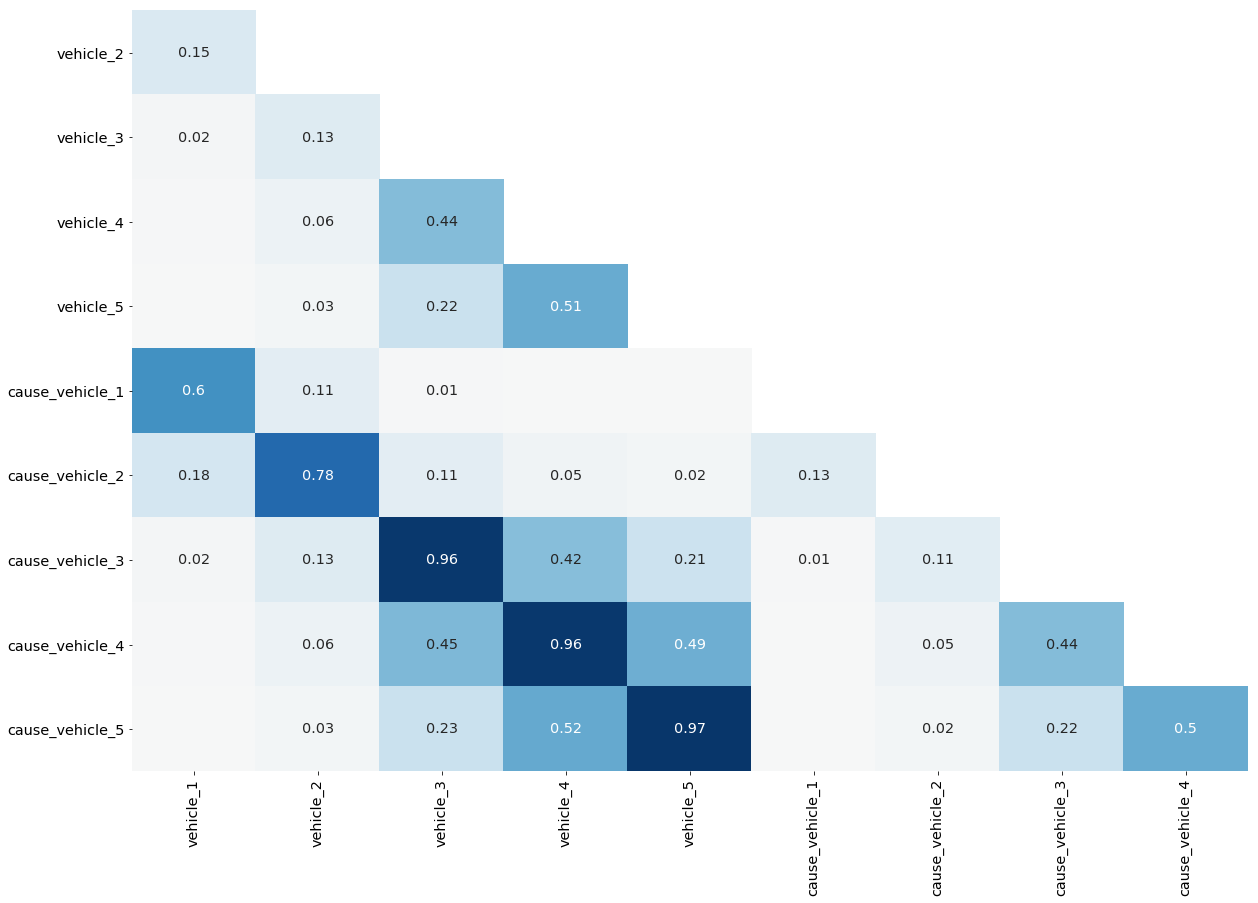

In [14]:
vehicle = [col for col in mvc.columns if 'vehicle' in col]
plot_null_correlations(mvc[vehicle])

In [16]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[v_col].notnull() & mvc[c_col].isnull()).sum()
    
    vc_null_data.append([v,v_null,c_null])
    
vc_null_df = pd.DataFrame(vc_null_data,columns=col_labels)

In [17]:
vc_null_df.isnull().sum()

v_number           0
vehicle_missing    0
cause_missing      0
dtype: int64

In [18]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]
v = mvc[v_cols]

v_1d = v.stack()

top10_vehicles = v_1d.value_counts().head(10)

In [19]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

In [20]:
summary_before = summarize_missing()

In [21]:
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    v_null = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_null = mvc[c_col].isnull() & mvc[v_col].notnull()
    
    mvc[v_col] = mvc[v_col].mask(v_null,'Unspecified')
    mvc[c_col] = mvc[c_col].mask(c_null,'Unspecified')

In [22]:
summary_after = summarize_missing()

In [23]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]

In [24]:
print(location_data.isnull().sum())

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64


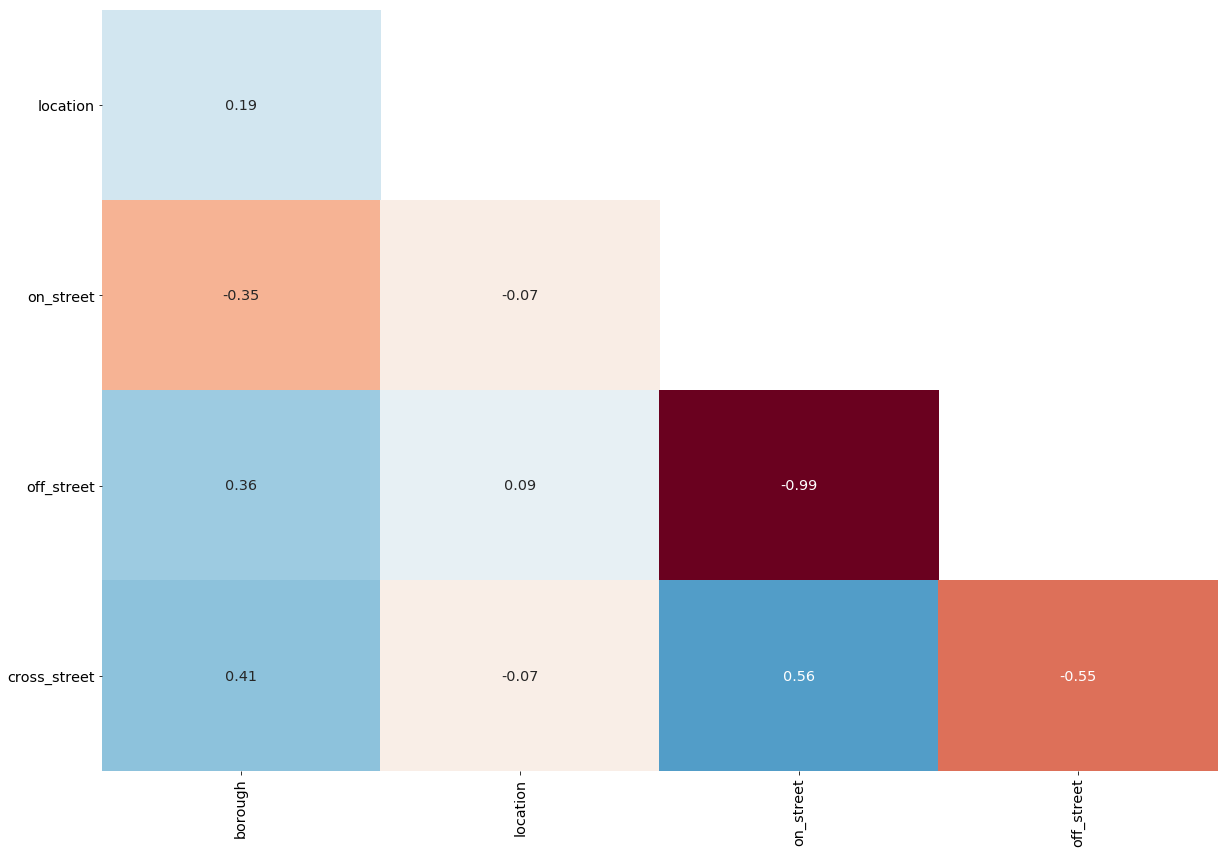

In [25]:
plot_null_correlations(location_data)

In [27]:
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

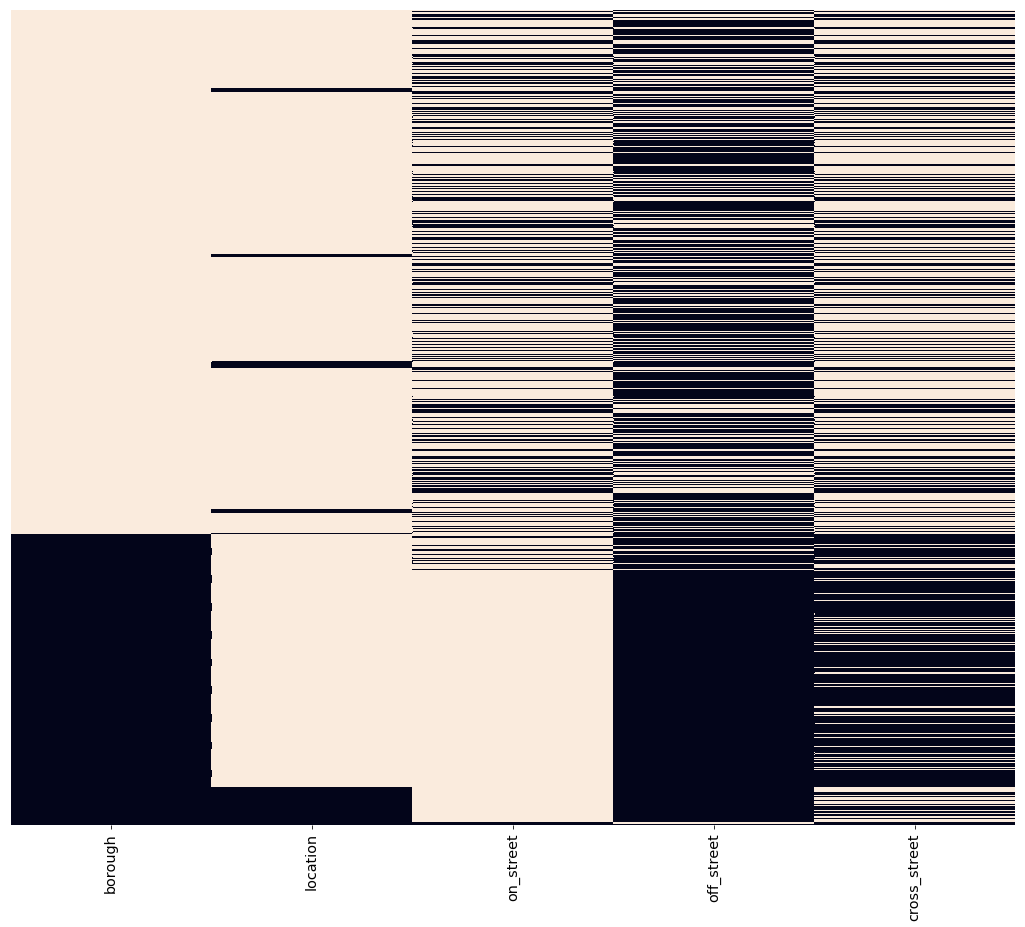

In [28]:
sorted_location_data = location_data.sort_values(loc_cols)
plot_null_matrix(sorted_location_data)

In [30]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

for col in location_cols:
    mvc[col] = mvc[col].mask(mvc[col].isnull(),sup_data[col])
    
null_after = mvc[location_cols].isnull().sum()

In [31]:
null_after

location         77
on_street     13734
off_street    36131
borough         232
dtype: int64